## ESE 5460 - Fall 2023
### Final Project, Team 42

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import gdown
from scipy.spatial.transform import Rotation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def positional_encoding(x, num_frequencies=6, incl_input=True):
    results = []
    if incl_input:
        results.append(x)
        
    # encode input tensor and append the encoded tensor to the list of results.
    freq = torch.pow(2,torch.arange(num_frequencies)).to(device)
    sin_list = torch.sin(torch.pi*freq*x.reshape((-1,1))).to(device)
    cos_list  = torch.cos(torch.pi*freq*x.reshape((-1,1))).to(device)
    results.append(sin_list.reshape((x.shape[0],-1)))
    results.append(cos_list.reshape((x.shape[0],-1)))
    
    return torch.cat(results, dim=-1)

    # prepend = 1 if incl_input else 0
    # enc_sz = x.shape[1] * (prepend + 2 * num_frequencies)
    # res = torch.zeros((x.shape[0], enc_sz), device=x.device)
    # if incl_input:
    #     res[:, :x.shape[1]] = x
    # powers = torch.pow(2, torch.arange(num_frequencies, device=x.device)) # (L,)
    # sin_phases = powers[None, :, None] * torch.pi * x[:, None, :] # (N, L, D)
    # cos_phases = torch.pi / 2 - sin_phases
    # phases = torch.stack([sin_phases, cos_phases], dim=-2) # (N, L, 2, D)
    # flat = phases.flatten(1)
    # res[:, prepend*x.shape[1]:] = torch.sin(flat)
    # return res

In [3]:
url = "https://drive.google.com/file/d/15W2EK8LooxTMfD0v5vo2BnBMse5ZzlVj/view?usp=share_link"
gdown.download(url=url, output='lego_data.npz', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=15W2EK8LooxTMfD0v5vo2BnBMse5ZzlVj
To: /home/ubuntu/ese5460_project42/lego_data.npz
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.7M/12.7M [00:00<00:00, 158MB/s]


'lego_data.npz'

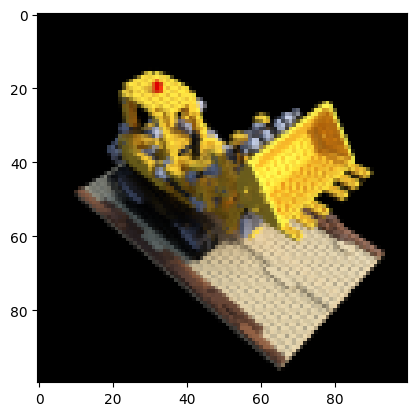

In [4]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

2.1 Complete the following function that calculates the rays that pass through all the pixels of an HxW image

In [5]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):

    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder

  
    coords = torch.stack(torch.meshgrid(torch.arange(height), torch.arange(width), indexing='xy'), -1).reshape((-1,2))
    coords = torch.concat((coords, torch.ones(coords.shape[0],1)), -1).to(device)
    # print(w_R_c.dtype, intrinsics.dtype, coords.dtype, w_T_c.dtype)
    rays = w_R_c @ torch.linalg.inv(intrinsics) @ coords.T
    # print(rays[:2,...])
    # print(rays.shape)
    rays = rays/torch.norm(rays, dim=0)
    rays_directions = rays.T.reshape((height,width,3))
    rays_origins = torch.broadcast_to(w_T_c.T, ((height, width,3)))
    # print(rays_directions.shape, rays_directions[0,:2,:])
    # print(rays_origins.shape, rays_origins[0,:2,:])
   
    return rays_origins, rays_directions

In [7]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):

    i = torch.arange(samples)
    depth = near + (i/samples)*(far-near)
    depth = depth.to(device)
    ray_points = torch.unsqueeze(ray_origins, dim=3) + torch.unsqueeze(ray_directions, dim = 3) * depth
    ray_points = ray_points.permute(0,1,3,2)
    depth_points = torch.broadcast_to(depth, (ray_origins.shape[0], ray_origins.shape[1], samples))

    return ray_points, depth_points

In [8]:
class nerf_model(nn.Module):


    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

        
        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(3*2*num_x_frequencies + 3, filter_size),
            'layer_2': nn.Linear(filter_size,filter_size),
            'layer_3': nn.Linear(filter_size,filter_size),
            'layer_4': nn.Linear(filter_size,filter_size),
            'layer_5': nn.Linear(filter_size,filter_size),
            'layer_6': nn.Linear(filter_size+3*2*num_x_frequencies + 3, filter_size),
            'layer_7': nn.Linear(filter_size,filter_size),
            'layer_8': nn.Linear(filter_size,filter_size),
            'layer_s': nn.Linear(filter_size,1),
            'layer_9': nn.Linear(filter_size,filter_size),
            'layer_10': nn.Linear(filter_size+3*2*num_d_frequencies + 3,filter_size//2),
            'layer_11': nn.Linear(filter_size//2, 3),
        })

   

    def forward(self, x, d):
       
        out = self.layers['layer_1'](x)
        out = F.relu(out)
        out = self.layers['layer_2'](out)
        out = F.relu(out)
        out = self.layers['layer_3'](out)
        out = F.relu(out)
        out = self.layers['layer_4'](out)
        out = F.relu(out)
        out = self.layers['layer_5'](out)
        out = F.relu(out)
        out = torch.concat([x,out], -1)
        out = self.layers['layer_6'](out)
        out = F.relu(out)
        out = self.layers['layer_7'](out)
        out = F.relu(out)
        out = self.layers['layer_8'](out)
        sigma = self.layers['layer_s'](out)
        sigma = F.relu(sigma)
        out = self.layers['layer_9'](out)
        out = F.relu(out)
        out = torch.concat([out, d], -1)
        out = self.layers['layer_10'](out)
        out = F.relu(out)
        out = self.layers['layer_11'](out)
        rgb = F.sigmoid(out)

       
        return rgb, sigma

In [9]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
       
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

    ray_directions = torch.unsqueeze(ray_directions, dim=2)
    ray_directions = torch.broadcast_to(ray_directions, ray_points.shape)
    # print('ray_direction shape:', ray_directions.shape)
    # print('ray points shape:', ray_points.shape)
    embed_ray_dir = positional_encoding(ray_directions.reshape((-1,3)), num_frequencies=num_d_frequencies, incl_input=True)
    embed_ray_point = positional_encoding(ray_points.reshape((-1,3)), num_frequencies=num_x_frequencies, incl_input=True)
    ray_points_batches = get_chunks(embed_ray_point)
    ray_directions_batches = get_chunks(embed_ray_dir)
    # ray_points_batches = torch.concat(ray_points_batches, 0)
    # ray_directions_batches = torch.concat(ray_directions_batches, 0)
    # print('ray_direction batches shape:', ray_directions_batches.shape)
    # print('ray points batches shape:', ray_points_batches.shape)
   

    return ray_points_batches, ray_directions_batches

In [10]:
def volumetric_rendering(rgb, s, depth_points):

    delta = depth_points[...,1:]  - depth_points[...,:-1]
    delta = torch.concat([delta, torch.ones((delta.shape[0], delta.shape[1], 1)).to(device)*1e9], -1) #
    inter_Ti = torch.exp(-s*delta)
    Ti = torch.concat([torch.ones((delta.shape[0], delta.shape[1], 1)).to(device),torch.cumprod(inter_Ti, dim=-1)[:,:,:-1]], -1)

    c = torch.unsqueeze(Ti, dim=-1) * (1-torch.unsqueeze(inter_Ti, dim=-1)) * rgb
    rec_image = torch.sum(c, dim=2)

 

    return rec_image

In [11]:
def one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies):

    

    pose = torch.Tensor(pose)
    # print(poses.dtype)
    w_R_c = pose[:3,:3]
    w_T_c = pose[:3,3]
    ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c.reshape((3,3)), w_T_c.reshape((3,1)))

    #sample the points from the rays
    ray_points, depth_points = stratified_sampling(ray_o, ray_d, near, far, samples)

    #divide data into batches to avoid memory errors
    ray_points_batches, ray_directions_batches = get_batches(ray_points, ray_d, num_x_frequencies, num_d_frequencies)
    rgb_list = []
    sigma_list =[]
    #forward pass the batches and concatenate the outputs at the end
    for batch_i in range(len(ray_points_batches)):
        #forward pass the batches and concatenate the outputs at the end
        rgb, sigma = model(ray_points_batches[batch_i], ray_directions_batches[batch_i])
        rgb_list.append(rgb)
        sigma_list.append(sigma)
        # Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(torch.concat(rgb_list, 0).reshape((height, width,samples, 3)), torch.concat(sigma_list,0).reshape((height, width, samples)), depth_points)


    return rec_image

In [12]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [13]:
criterion = torch.nn.MSELoss()

## Train pose regressor

In [147]:
class PoseReg(nn.Module):
    def __init__(self, nerf, initial_guess):
        super().__init__()
        
        self.nerf = nerf.to(device)
        self.pose_param = initial_guess.clone().to(device)
        self.pose_param.requires_grad_()
        # self.optimizer = torch.optim.SGD(self.nerf.parameters(), lr=1e-2)

    def execute(self, test_image):
        print(f'Before:\n{self.pose_param}')
        # self.nerf.zero_grad()
        # self.optimizer.zero_grad()
        recon = one_forward_pass(
            test_image.shape[0], test_image.shape[1], intrinsics, self.pose_param, near, far, samples,
            self.nerf, num_x_frequencies, num_d_frequencies
        )
        loss = nn.functional.mse_loss(recon, test_image)
        loss.backward()
        self.pose_param = - 0.1 * self.pose_param.grad.data + self.pose_param.detach()
        self.pose_param.requires_grad_()

        print(f'After:\n{self.pose_param}')
        
        return
        

In [151]:
model = nerf_model(num_x_frequencies=10, num_d_frequencies=4)
model.load_state_dict(torch.load('model_nerf_alt.pt'))

roll = 0.0
pitch = 0.0
yaw = 0.0
rot = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False).as_matrix()
se3 = torch.eye(4).to(device)
se3[:3, :3] = torch.from_numpy(rot).to(device)
se3[:3, 3] -= torch.tensor([-0.01, -0.05, -0.02]).to(device)

noisy_pose = se3 @ test_pose

pose_reg = PoseReg(model, noisy_pose)

In [156]:
test_pose

tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01, -6.5818e-01],
        [-7.2443e-01, -5.0789e-01,  4.6611e-01, -6.2631e-01],
        [ 1.4901e-08, -6.7615e-01, -7.3676e-01,  9.8999e-01],
        [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  1.0000e+00]], device='cuda:0')

In [152]:
def regress_pose(model, test_img, n_iter=5):
    
    for i in range(n_iter):
        model.execute(test_img.to(device))
    
    return model.pose_param.detach().cpu().numpy()

In [153]:
regress_pose(pose_reg, test_image, n_iter=100)

Before:
tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01, -6.4818e-01],
        [-7.2443e-01, -5.0789e-01,  4.6611e-01, -5.7631e-01],
        [ 1.4901e-08, -6.7615e-01, -7.3676e-01,  1.0100e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
       requires_grad=True)
After:
tensor([[ 6.9040e-01, -5.3714e-01,  4.6307e-01, -6.6477e-01],
        [-7.3282e-01, -5.1470e-01,  3.9766e-01, -6.2765e-01],
        [ 5.2639e-04, -6.7705e-01, -7.8063e-01,  9.6878e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
       requires_grad=True)
Before:
tensor([[ 6.9040e-01, -5.3714e-01,  4.6307e-01, -6.6477e-01],
        [-7.3282e-01, -5.1470e-01,  3.9766e-01, -6.2765e-01],
        [ 5.2639e-04, -6.7705e-01, -7.8063e-01,  9.6878e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
       requires_grad=True)
After:
tensor([[ 0.6952, -0.5393,  0.4984, -0.6277],
        [-0.7312, -0.5133,  0.4253, -0.5949],

array([[ 0.7873153 , -0.59585035,  0.4942389 , -0.6720812 ],
       [-0.81761265, -0.555902  ,  0.4388891 , -0.584737  ],
       [ 0.03290799, -0.7519462 , -0.7451445 ,  0.95821327],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [16]:
def guess_pose(model, test_img, initial_guess=torch.eye(4), learning_rate=1e-4, n_iter=5):
    model.to(device)
    pose_param = initial_guess.clone().to(device)
    pose_param.requires_grad_()
    grad = torch.zeros_like(pose_param).to(device)
    for i in range(n_iter):
        with torch.enable_grad():
            print(i)
            model.zero_grad()
            recon = one_forward_pass(
                height, width, intrinsics, pose_param, near, far, samples,
                model, num_x_frequencies, num_d_frequencies
            )

            plt.imshow(recon.detach().cpu().numpy())

            print(recon.shape)
            print(test_image.shape)
            
            loss = nn.MSELoss(recon, test_img)
            grad = torch.autograd.grad(loss, [pose_param])[0].detach()
            print(grad.shape)
            pose_param = pose_param - learning_rate * grad
            print(pose_param.shape)
    
    return pose_param.detach().cpu().numpy()

In [17]:
# guess_pose(model, test_image)

Error term:
tensor([[ 0.9239, -0.3827,  0.0000, -0.5000],
        [ 0.3827,  0.9239,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Old pose:
tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01, -6.5818e-01],
        [-7.2443e-01, -5.0789e-01,  4.6611e-01, -6.2631e-01],
        [ 1.4901e-08, -6.7615e-01, -7.3676e-01,  9.8999e-01],
        [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  1.0000e+00]], device='cuda:0')
New pose:
tensor([[ 9.1410e-01, -2.9874e-01,  2.7417e-01, -8.6840e-01],
        [-4.0548e-01, -6.7348e-01,  6.1807e-01, -8.3051e-01],
        [ 1.4901e-08, -6.7615e-01, -7.3676e-01,  9.8999e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


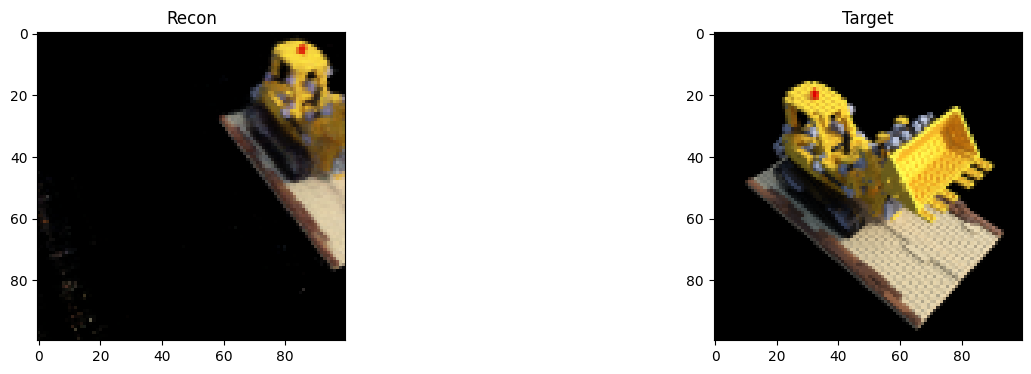

In [44]:
# study pose perturbations
with torch.no_grad():
    model = nerf_model(num_x_frequencies=10, num_d_frequencies=4)
    model.load_state_dict(torch.load('model_nerf_alt.pt'))
    model.to(device)

    roll = 0.0
    pitch = 0.0
    yaw = np.pi / 8
    rot = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False).as_matrix()
    se3 = torch.eye(4).to(device)
    se3[:3, :3] = torch.from_numpy(rot).to(device)
    se3[:3, 3] -= torch.tensor([0.5, 0, 0]).to(device)

    print(f'Error term:\n{se3}')
    print(f'Old pose:\n{test_pose}')
    print(f'New pose:\n{se3 @ test_pose}')
    
    test_rec_image = one_forward_pass(height, width, intrinsics, se3 @ test_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.imshow(test_rec_image.detach().cpu().numpy())
    plt.title("Recon")
    plt.subplot(122)
    plt.imshow(test_image.detach().cpu().numpy())
    plt.title("Target")
    # plt.savefig(os.path.join(vis_path), f'training_interm_{i}.png')
    plt.show()